In [7]:
import numpy as np
%matplotlib inline

import pandas as pd

%pylab inline
#import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table
from astropy.io import fits
from importlib import reload
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm
from decimal import *
import sys
from scipy.ndimage import zoom 
from mpl_toolkits.axes_grid.inset_locator import inset_axes

import input
reload (input)
from input import *

import procedures
reload (procedures)
from procedures import *

#print('reading chain %0.2f 0.2f ' % ((xmass[kk]-obs_bin/2.),(xmass[kk]+obs_bin/2))         

print('reading chains %s' % chains_file)

#find number of steps combining all chains
N_steps=0
for ii in range(0,N_chains):
    char_ii="%d" % ii
    df=pd.read_csv(chains_dir+chains_file+'_'+char_ii+'.txt',sep=' ',
                  names=['0','1','2','3','4','5','6','7','8','9',
                         '10','11','12','13','14','15','16'])  
 
    #print('chain %d, steps=%d' % (ii, len(df.index)))
    N_steps+=len(df.index)     
print("Total Steps:", N_steps)
N_steps=N_steps-(Burn_In*N_chains)
print("Excluding %d BurnIn steps:" % Burn_In, N_steps)
print("")

#create data frame with total size
df=pd.DataFrame(np.zeros((N_steps,N_par+2),dtype=np.float64),
                columns=['0','1','2','3','4','5','6','7','8','9',
                         '10','11','12','13','14','15','16'])


#read individual chains into big data frame
offset=0

for ii in range(0,N_chains):
    char_ii="%d" % ii  
    aux_df=pd.read_csv(chains_dir+chains_file+'_'+char_ii+'.txt',sep=' ',header=None,
                      names=['0','1','2','3','4','5','6','7','8','9',
                             '10','11','12','13','14','15','16'])   
    #iloc - position based (to ignore the indexes), loc - label based
    short_aux_df=aux_df[Burn_In:len(aux_df.index)]
    #the indexes in df and aux_df must be exactly the same, otherwise all nans
    short_aux_df = short_aux_df.set_index(np.arange(int(offset),int(offset+len(aux_df.index)-Burn_In)))
    df.iloc[offset:offset+len(aux_df.index)-Burn_In] = short_aux_df   
    offset+=(len(aux_df.index)-Burn_In)  


#prior on some parameter value
#df=df[df.iloc[:,2] > np.log10(0.05)]    
#df=df[df.iloc[:,3] > np.log10(0.1)]    
#df=df[df.iloc[:,5] > np.log10(0.001)]    
#df=df[df.iloc[:,14] < np.log10(1.8e10)]    

    
''';coldgas crit parameter has new normalization
;;data(j,3,*)=Alog10(10^data(j,3,*)*2.)
;radio mode feedback parameter has new normalization
;1.25 meaningless, just to get the right value
;;data(j,6,*)=Alog10(10^data(j,6,*)*0.673*0.673*1.25)'''
     
#print stats:
print('Max Log10(Like)=%0.8g' % min(df.iloc[:,1]))
#print('Max Log10(Like)=%0.8g' % min(df.loc[:,'1']))
#print('Max Log10(Like)=%0.8g' % min(df.values[:,'1']))
#print('Max Log10(Like)=%0.8g' % min(df.values[:,1]))

#select all best fit steps
best_fit_steps=df[df.iloc[:,1] == min(df.iloc[:,1])]
'''for ii, item in enumerate(best_fit_steps.iloc[0]):   # default is zero
    if(ii>1):
        print('Par[%d]=%0.2g ' % (ii-2, 10**item), end="")'''
for ii, item in enumerate(best_fit_steps.iloc[0,:]):   # default is zero
    if(ii>1):
        print('%0.2g ' % (10**item), end="")
        
print("")
print("")
bestfit=best_fit_steps.iloc[0,:]
#print(min(df.iloc[:,1])*1.2)
#df=df[df.iloc[:,1] < min(df.iloc[:,1])*2.0]
#max_log_like=35
df=df[df.iloc[:,1] < max_log_like]





print('max_log_like',max_log_like)
print("Nsteps after limiting like:",len(df))


#sel_df=df[df.iloc[:,8] < np.log10(0.2)]
#print(10**sel_df.iloc[0,:])

#sel_df=df[df.iloc[:,8] > np.log10(7.)]
#print(10**sel_df.iloc[0,:])



print("")
print("")
print("Reading done")

#print(best_fit_steps.iloc[0].to_frame().T)

Populating the interactive namespace from numpy and matplotlib
reading chains senna_g0
Total Steps: 19407
Excluding 0 BurnIn steps: 19407

Max Log10(Like)=11.862903
0.07 0.38 1.1 0.0044 0.05 5.3e+02 6.3 1.3e+02 1.9 8.4 2.1e+02 1.7 1.3e+10 2.1 4.9e+04 

max_log_like 300.0
Nsteps after limiting like: 19407


Reading done


## Marginalized Statistics

In [8]:
def ConfidVal(ix, limfrac, upper, nrows):    
    l=0
    t=nrows
 
    try_b = min(df.iloc[:,ix])
    try_t = max(df.iloc[:,ix])
   
    samps = sum(df.iloc[l:t,0])
         
    lasttry = -1    
   

    if (upper==1):

        while True:        
            aux=df.iloc[:,ix]       
            sel=aux > (try_b + try_t)/2
            var_try=len(aux[sel])
            if (var_try > samps*limfrac):
                try_b = (try_b+try_t)/2 
            else:
                try_t = (try_b+try_t)/2
        
            if (var_try==lasttry): break
            lasttry = var_try      
    else:   
        while True:
            aux=df.iloc[:,ix]       
            sel=aux < (try_b + try_t)/2
            var_try=len(aux[sel])
            if (var_try>samps*limfrac):
                try_t = (try_b+try_t)/2 
            else:
                try_b = (try_b+try_t)/2
    
            if (var_try==lasttry): break
            lasttry = var_try
     
    
    
    return (try_t)

for ii in range (0, N_par):   
    
    #compute regions
    upper=ConfidVal(ii+2,(1-0.955)/2.,1, N_steps)   
    lower=ConfidVal(ii+2,(1-0.955)/2.,0, N_steps) 
          
    #best fit
    if(fix_max_like == 0):
        aux=df[df.iloc[:,1] == min(df.iloc[:,1])].iloc[0]   
    else:
        aux=df[df.iloc[:,1] == max_log_like].iloc[0]        
        
    if(ii==0):
        print(' par','  best fit','     lower','      upper')    
        
    #print, ii, 10^aux(0,0,0), 10^lower, 10^upper, aux(0,0,0), lower, upper     
    print("  %d" % ii, end="" )
    
    if(ii<10):
        for jj in range (0,12-len("%0.2g" % 10**aux[ii+2])):
            print(" ", end="");
    else:
        for jj in range (0,11-len("%0.2g" % 10**aux[ii+2])):
            print(" ", end="");            
    print("%0.2g" % (10**aux[ii+2]), end="" )
    
    for jj in range (0,11-len("%0.2g" % 10**lower)):
            print(" ", end="");            
    print("%0.2g" % (10**lower), end="")
    
    for jj in range (0,11-len("%0.2g" % 10**upper)):
            print(" ", end="");            
    print("%0.2g" % (10**upper))
    
    #print("  %d    %0.2g    %0.2g    %0.2g" % (ii, 10**aux[ii+2], 10**lower, 10**upper) )
    
    #print("  %d    %0.2g    %0.2g    %0.2g" % (ii, 10**aux[ii+2], 10**lower, 10**upper) )
        
        
print("")
    
#select bestfit inside MCMC 2-sigma regions

upper=np.zeros(N_par,dtype=np.float64)
lower=np.zeros(N_par,dtype=np.float64)

for ii in range (0, N_par):   
    
    #compute regions
    upper[ii]=ConfidVal(ii+2,(1-0.955)/2.,1, N_steps)   
    lower[ii]=ConfidVal(ii+2,(1-0.955)/2.,0, N_steps) 
    
    if(ii==0):
        sel=(df.iloc[:,ii+2]>lower[ii]) & (df.iloc[:,ii+2]<upper[ii])
        df_inside_2sigma=df[sel]
    else:
        sel=(df_inside_2sigma.iloc[:,ii+2]>lower[ii]) & (df_inside_2sigma.iloc[:,ii+2]<upper[ii])
        df_inside_2sigma=df_inside_2sigma[sel]
    
    
#select all best fit steps
best_fit_inside_2sigma=df_inside_2sigma[df.iloc[:,1] == min(df_inside_2sigma.iloc[:,1])]
for ii, item in enumerate(best_fit_inside_2sigma.iloc[0,:]):   # default is zero
    if(ii>1):
        print('%0.2g ' % (10**item), end="")
print("")
best_fit_inside_2sigma=best_fit_inside_2sigma.iloc[0,:]



 par   best fit      lower       upper
  0        0.07      0.046       0.09
  1        0.38        0.3       0.62
  2         1.1       0.29       0.63
  3      0.0044     0.0018     0.0037
  4        0.05      0.049      0.093
  5     5.3e+02      5e+02    9.3e+02
  6         6.3        4.4        8.7
  7     1.3e+02         85    1.6e+02
  8         1.9          2        3.5
  9         8.4          4        7.9
  10    2.1e+02    1.5e+02    3.1e+02
  11        1.7        1.3        2.9
  12    1.3e+10    8.7e+09    1.8e+10
  13        2.1        1.3        2.5
  14    4.9e+04    3.6e+04    7.5e+04

0.081 0.31 0.43 0.0018 0.076 5.5e+02 5.7 1.1e+02 3.5 6.7 3.1e+02 1.4 1.4e+10 2.5 5.6e+04 


/usr/lib/python3/dist-packages/ipykernel_launcher.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## 1D Plots

In [56]:
plt.rcParams.update({'xtick.direction': 'in', 'ytick.direction': 'in'})
plt.rcParams.update({'xtick.top': 'on', 'ytick.right': 'on'})

def smooth(array, N):

    for jj in range(0, N):
        for ii in range (1, len(array)-2):
            array[ii]=(array[ii-1]+array[ii]+array[ii+1])/3.
        
    return(array)

import input
reload (input)
from input import *

plots_in_log=1

plt.rcParams.update({'font.size': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 1.5, 
                     'ytick.major.size': 6, 'ytick.major.width': 1.5, 
                     'xtick.minor.size': 3, 'xtick.minor.width': 1.,                   
                     'ytick.minor.size': 3, 'ytick.minor.width': 1.})  


fig_idx=0
with PdfPages('./fig/plots.pdf') as pdf:  
                
    for ii in range (0, N_par): 
        
        
        #parameter_corrections
        '''if(ii==0):
            df.iloc[:,ii+2] += 0.2
            lower[ii]+=0.2
            upper[ii]+=0.2
            
        if(ii==1):
            df.iloc[:,ii+2] += 0.6
            lower[ii]+=0.6
            upper[ii]+=0.6    
            
        if(ii==3):
            df.iloc[:,ii+2] += 0.4
            lower[ii]+=0.4
            upper[ii]+=0.4      
            
        if(ii==12):
            df.iloc[:,ii+2] -= 0.2
            lower[ii]-=0.2
            upper[ii]-=0.2  '''
   
        if((ii==0) | (ii==5) | (ii==10)):
            fig = plt.figure(figsize=(22,5))
            grid = gridspec.GridSpec(1, 5)            
            i_grid=0
              
        subplot=plt.subplot(grid[i_grid])
        i_grid+=1
        if(plots_in_log==1):          
            interval=abs(max(df.iloc[:,ii+2])-min(df.iloc[:,ii+2]))
            mean=(min(df.iloc[:,ii+2])+max(df.iloc[:,ii+2]))/2.           
            #xlim=[mean-interval/2.,mean+interval/2.]         
            xlim=[mean-interval*2,mean+interval*2]         
        else:
            xlim=[10**min(df.iloc[:,ii+2]),10**max(df.iloc[:,ii+2])]                   
            median=(xlim[1]+xlim[0])/2.
            #interval is 0.2 in log space
            xlim=[median-median*2./3,median+median*0.5]  
        
        
        ylim=[0.0, 1.0]         
        subplot.set_ylim(ylim), subplot.set_xlim(xlim)
           
        
        #format axis
        majorFormatter = FormatStrFormatter('%d')
        xaxis_locator = 0.5
        subplot.xaxis.set_major_locator(MultipleLocator(xaxis_locator))    
        subplot.xaxis.set_minor_locator(MultipleLocator(0.5)) 
                          
        subplot.set_xlabel('$\log_{10}($'+Par_Names[ii+2]+')', fontsize=16) 
        if((ii==0) | (ii==5) | (ii==10)):
            subplot.set_ylabel('fraction', fontsize=14)    
            
        if((ii!=0) and (ii!=5) and (ii!=10)):
            plt.tick_params(axis='y', which='both', left=True, labelleft=False)
            
        #bin=(Alog10(xmax)-Alog10(xmin))/float(Nbins)
        #hist=histogram(Alog10(data[j,i+2,*]),locations=c,min=alog10(xmin)-bin*2.,max=alog10(xmax)+bin*2.,binsize=bin)
        #c=10^(c+bin/2.)                       
        #      oplot,c,hist/(total(hist))/max(hist/(total(hist))), color=color[j], thick=6 
                
        #Histograms    
        Nbins=40   
        if(plots_in_log==1):
            log_xlim=xlim
        else:
            log_xlim=np.log10(xlim)
        bin=(log_xlim[1]-log_xlim[0])/float(Nbins)
        bin_arr=np.arange(log_xlim[0],log_xlim[1]+bin,bin)
        hist=np.histogram(df.iloc[:,ii+2], bins=bin_arr, range=(log_xlim[0],log_xlim[1]))      
        x_axis=hist[1][0:len(hist[1][:])-1]+bin/2.           
        #y_axis=(hist[0]/sum(hist[0]))        
        y_axis=smooth(hist[0], 2)
        y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
        if(plots_in_log==1):
            subplot.plot(x_axis,y_axis, color='blue', linewidth=2, linestyle='-') 
        else:
            subplot.plot(10**x_axis,y_axis, color='blue', linewidth=2, linestyle='-')
        
        df_output=pd.DataFrame({'x':10**x_axis, 'y':y_axis})      
        char_ii="%d" % ii
        df_output.to_csv(chains_dir+chains_file+'_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
            
            
        #plot 2-sigma regions       
        sel=(x_axis>lower[ii]) & (x_axis<upper[ii])
        if(plots_in_log==1):
            subplot.fill_between(x_axis[sel],x_axis[sel]/x_axis[sel]-1.,y_axis[sel],facecolor='skyblue', 
                                 interpolate=True, alpha=0.4, edgecolor='skyblue')  
        else:
            subplot.fill_between(10**x_axis[sel],x_axis[sel]/x_axis[sel]-1.,y_axis[sel],facecolor='skyblue', 
                                 interpolate=True, alpha=0.4, edgecolor='skyblue')

        #Maximum likelihood
        #max_like=df[df.iloc[:,1] == min(df.iloc[:,1])].iloc[0]     
        #y_axis=np.arange(0.01,1,0.01)
        #x_axis=y_axis/y_axis-1.+max_like[ii+2]
        #if(plots_in_log==1):
        #    subplot.plot(x_axis,y_axis, color='royalblue', linewidth=3, linestyle='-')
        #else:
        #    subplot.plot(10**x_axis,y_axis, color='royalblue', linewidth=3, linestyle='-')
        
        #best_fit_inside_2sigma
        #y_axis=np.arange(0.01,1,0.01)
        #x_axis=y_axis/y_axis-1.+best_fit_inside_2sigma[ii+2]
        #if(plots_in_log==1):
        #    subplot.plot(x_axis,y_axis, color='royalblue', linewidth=3, linestyle='--')
        #else:
        #    subplot.plot(10**x_axis,y_axis, color='royalblue', linewidth=3, linestyle='--')
            
        #plot other chains
        #if(plot_other_chains==1):
            #df_previous1=pd.read_csv(chains_dir+'senna_g0_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
            #if(plots_in_log==1):
            #    subplot.plot(np.log10(df_previous1['x'][:]),df_previous1['y'], color='red', linewidth=2, linestyle='-') 
            #else:
            #    subplot.plot(df_previous1['x'][:],df_previous1['y'], color='red', linewidth=2, linestyle='-')

            #df_previous2=pd.read_csv(chains_dir+'senna_g2_1D_histogram_par_'+char_ii+'.txt',sep=' ')   
            #if(plots_in_log==1):
            #    subplot.plot(np.log10(df_previous2['x'][:]),df_previous2['y'], color='green', linewidth=2, linestyle='-') 
            #else:
            #    subplot.plot(df_previous2['x'][:],df_previous2['y'], color='green', linewidth=2, linestyle='-') 
        
        
        #Maximum likelihood - BEST FIT 
        y_axis=np.arange(0.01,1,0.01)
        x_axis=y_axis/y_axis-1.+np.log10(Hen19_best_fit[ii])
        if(plots_in_log==1):
            subplot.plot(x_axis,y_axis, color='royalblue', linewidth=3, linestyle='-')
        else:
            subplot.plot(10**x_axis,y_axis, color='royalblue', linewidth=3, linestyle='-')
            
        #Hen15    
        y_axis=np.arange(0.01,1,0.01)
        x_axis=y_axis/y_axis-1.+np.log10(Hen15_best_fit[ii])
        if(plots_in_log==1):
            subplot.plot(x_axis,y_axis, color='green', linewidth=3, linestyle='--')
        else:
            subplot.plot(10**x_axis,y_axis, color='green', linewidth=3, linestyle='--')
            
        #Guo11    
        y_axis=np.arange(0.01,1,0.01)
        x_axis=y_axis/y_axis-1.+np.log10(Guo11_best_fit[ii])
        if(plots_in_log==1):
            subplot.plot(x_axis,y_axis, color='red', linewidth=3, linestyle='--')
        else:
            subplot.plot(10**x_axis,y_axis, color='red', linewidth=3, linestyle='--')
        
        
        
        ax2 = subplot.twiny()  # instantiate a second axes that shares the same y-axis
        ax2.set_xlim(xlim)
        arr = np.arange(-12,12,xaxis_locator)
        sel = (arr>xlim[0]) & (arr<xlim[1])
                
        ax2.set_xticks(arr[sel])
        labels = [f'{10**xx:0.1g}' for xx in arr[sel]]
        ax2.set_xticklabels(labels)

        ax2.set_xlabel(Par_Names[ii+2], fontsize=16) 
        ax2.xaxis.set_label_position('top')  
        
                        
        
        if((ii==4) | (ii==9) | (ii==N_par-1)): 
            plt.tight_layout() 
            grid.update(wspace=0.05, hspace=0.0)
            pdf.savefig()
            plt.savefig('./fig/mcmc_1d_'+str(fig_idx)+'.pdf')
            fig_idx+=1
            plt.close()

print("plots done")

/usr/lib/python3/dist-packages/ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in log10


plots done


## 1D Plots: combine multiple runs

In [10]:
plt.rcParams.update({'xtick.direction': 'in', 'ytick.direction': 'in'})
plt.rcParams.update({'xtick.top': 'on', 'ytick.right': 'on'})

def smooth(array, N):

    for jj in range(0, N):
        for ii in range (1, len(array)-2):
            array[ii]=(array[ii-1]+array[ii]+array[ii+1])/3.
        
    return(array)

import input
reload (input)
from input import *

plt.rcParams.update({'font.size': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 1.5, 
                     'ytick.major.size': 6, 'ytick.major.width': 1.5, 
                     'xtick.minor.size': 3, 'xtick.minor.width': 1.,                   
                     'ytick.minor.size': 3, 'ytick.minor.width': 1.})  


fig_idx=0

#xlim_low =  [-1.7, -0.7, -1.0, -3.0, -1.5, 2.5, 0.5, 1.5, 0.0, 0.3, 2.0, 0.0,  9.5, 0.0, 4.2]
#xlim_high = [-0.7,  0.3,  0.0, -2.0, -0.5, 3.5, 1.5, 2.5, 1.0, 1.3, 3.0, 1.0, 10.5, 1.0, 5.2]

with PdfPages('./fig/plots.pdf') as pdf:  
                
    for ii in range (0, N_par): 
    #for ii in range (0, 2):     
        
        if((ii==0) | (ii==7) | (ii==14)):
            fig = plt.figure(figsize=(22,4))
            grid = gridspec.GridSpec(1, 7)            
            i_grid=0
              
        subplot=plt.subplot(grid[i_grid])
        i_grid+=1
                 
        xlim=[np.log10(Hen19_best_fit[ii])-0.5,np.log10(Hen19_best_fit[ii])+0.5]         
               
        
        ylim=[0.0, 1.0]         
        subplot.set_ylim(ylim), subplot.set_xlim(xlim)
           
        
        #format axis
        majorFormatter = FormatStrFormatter('%d')
        subplot.xaxis.set_major_locator(MultipleLocator(0.5))    
        subplot.xaxis.set_minor_locator(MultipleLocator(0.5)) 
                          
        subplot.set_xlabel(Par_Names[ii+2], fontsize=14) 
        if((ii==0) | (ii==7) | (ii==14)):
            subplot.set_ylabel('fraction', fontsize=14)    
            
        if((ii!=0) and (ii!=7) and (ii!=14)):
            plt.tick_params(axis='y', which='both', left=True, labelleft=False)
            
         
        #Histograms       
        bin=0.1
        bin_arr=np.arange(-20.0,20.0,bin)
        hist = np.zeros(len(bin_arr))
        for idx in range(0, len(bin_arr)):
            sel = (df.iloc[:,ii+2]>bin_arr[idx]-bin/2.0) & (df.iloc[:,ii+2]<bin_arr[idx]+bin/2.0)
            if(len(df[sel].iloc[:,ii+1])>0.):
                hist[idx] = np.mean(df[sel].iloc[:,1])
                hist[idx] = min(df[sel].iloc[:,1])
            else:
                hist[idx] = 300.0
        
        #hist=np.histogram(df.iloc[:,ii+2], bins=bin_arr)      
        #x_axis=hist[1][0:len(hist[1][:])-1]+bin/2.                   
        #y_axis=smooth(hist[0], 2)
        #y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
        sel = (bin_arr>xlim[0]) & (bin_arr<xlim[1])
        x_axis = bin_arr[sel]
        y_axis=10**(-hist[sel])       
        y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
        subplot.plot(x_axis,y_axis, color='green', linewidth=2, linestyle='-') 
        
        df_output=pd.DataFrame({'x':10**x_axis, 'y':hist[sel]})      
        char_ii="%d" % ii
        df_output.to_csv(chains_dir+chains_file+'_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
                 
            
        #plot other chains
        if(plot_other_chains==1):
            df_previous0=pd.read_csv(chains_dir+'/individual_const/senna_g0_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
            y_axis=10**(-df_previous0['y'])      
            y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
            subplot.plot(np.log10(df_previous0['x'][:]),y_axis, color='purple', linewidth=2, 
                         linestyle='-') 
            
            df_previous1=pd.read_csv(chains_dir+'/individual_const/senna_g1_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
            y_axis=10**(-df_previous1['y'])      
            y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
            subplot.plot(np.log10(df_previous1['x'][:]),y_axis, color='blue', linewidth=2, 
                         linestyle='-') 
            
            df_previous2=pd.read_csv(chains_dir+'/individual_const/senna_g2_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
            y_axis=10**(-df_previous2['y'])      
            y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
            subplot.plot(np.log10(df_previous2['x'][:]),y_axis, color='red', linewidth=2, 
                         linestyle='-') 
            
            df_previous3=pd.read_csv(chains_dir+'/individual_const/senna_g3_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
            y_axis=10**(-df_previous3['y'])      
            y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
            subplot.plot(np.log10(df_previous2['x'][:]),y_axis, color='orange', linewidth=2, 
                         linestyle='-') 
            
            #df_previous1=pd.read_csv(chains_dir+'senna_g0_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
            #y_axis=10**(-df_previous1['y'])      
            #y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
            #subplot.plot(np.log10(df_previous1['x'][:]),y_axis, color='red', linewidth=2, 
            #             linestyle='--') 
                       
        
        df_previous0=pd.read_csv(chains_dir+'/individual_const/senna_g0_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
        df_previous1=pd.read_csv(chains_dir+'/individual_const/senna_g1_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
        df_previous2=pd.read_csv(chains_dir+'/individual_const/senna_g2_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
        df_previous3=pd.read_csv(chains_dir+'/individual_const/senna_g3_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
        df_previous4=pd.read_csv(chains_dir+'/individual_const/senna_g4_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
        
        
        p0 = 10**(-df_previous0['y'])
        p1 = 10**(-df_previous1['y'])
        p2 = 10**(-df_previous2['y'])
        p3 = 10**(-df_previous3['y'])
        p4 = 10**(-df_previous4['y'])
        w0 = 1.
        w1 = 0.
        w2 = 1.
        w3 = 1.
        w4 = 1.
        Hen19_best_fit[ii]
        #e^x/e^(x-xw) = e^(xw)
        #e^x = p
        y_axis = ( p0/np.exp(np.log(p0)-np.log(p0)*w0) * 
                   p1/np.exp(np.log(p1)-np.log(p1)*w1) *
                   p2/np.exp(np.log(p2)-np.log(p2)*w2) *
                   p3/np.exp(np.log(p3)-np.log(p3)*w3) *
                   p4/np.exp(np.log(p4)-np.log(p4)*w4) )
        #y_axis = p0 * p1
        y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
        subplot.plot(np.log10(df_previous0['x']),y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis))), 
                     color='black', linewidth=2, linestyle='-') 
      
        sel = (y_axis == max(y_axis))      
        print(f"{df_previous0.loc[sel,'x'].values[0]:0.2g} ", end = '')
        
        #Maximum likelihood - BEST FIT 
        y_axis=np.arange(0.01,1,0.01)
        x_axis=y_axis/y_axis-1.+np.log10(Hen19_best_fit[ii])
        subplot.plot(x_axis,y_axis, color='black', linewidth=3, linestyle='-')
        
        y_axis=np.arange(0.01,1,0.01)
        x_axis=y_axis/y_axis-1.+np.log10(MCMC_best_fit[ii])
        subplot.plot(x_axis,y_axis, color='red', linewidth=3, linestyle='--')
       
        #x_axis=y_axis/y_axis-1.+best_fit_inside_2sigma[ii+2]
        #subplot.plot(x_axis,y_axis, color='royalblue', linewidth=3, linestyle='-')
        
        
        if((ii==6) | (ii==13) | (ii==N_par-1)): 
            plt.tight_layout() 
            grid.update(wspace=0.05, hspace=0.0)
            pdf.savefig()
            plt.savefig('./fig/mcmc_1d_'+str(fig_idx)+'.pdf')
            fig_idx+=1
            plt.close()
            
#[0.43715912 2.         0.         1.         2.         4.        ]
#0.063 0.5 0.4 0.0025 0.063 7.9e+02 6.3 1e+02 3.2 6.3 2e+02 2 1.3e+10 1.6 5e+04 
#0.063 0.5 0.4 0.0032 0.063 5e+02 5 1.3e+02 3.2 6.3 2e+02 2.5 1.3e+10 1.6 5e+04
print("\n\nplots done")

0.063 0.5 0.4 0.0032 0.063 5e+02 5 1.3e+02 3.2 6.3 2e+02 2.5 1.3e+10 1.6 5e+04 

plots done


In [62]:
char_ii="%d" % 0
df_previous0=pd.read_csv(chains_dir+'/individual_const/senna_g0_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
df_previous1=pd.read_csv(chains_dir+'/individual_const/senna_g1_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
df_previous2=pd.read_csv(chains_dir+'/individual_const/senna_g2_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
df_previous3=pd.read_csv(chains_dir+'/individual_const/senna_g3_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
df_previous4=pd.read_csv(chains_dir+'/individual_const/senna_g4_1D_histogram_par_'+char_ii+'.txt',sep=' ')  

df_previous0['x0'] = df_previous0['x']
df_previous0['y0'] = df_previous0['y']
df_previous1['x0'] = df_previous1['x']
df_previous1['y0'] = df_previous1['y']
df_previous2['x0'] = df_previous2['x']
df_previous2['y0'] = df_previous2['y']
df_previous3['x0'] = df_previous3['x']
df_previous3['y0'] = df_previous3['y']
df_previous4['x0'] = df_previous4['x']
df_previous4['y0'] = df_previous4['y']


for ii in range (1, N_par):     
    char_ii="%d" % ii         
    df_previous0_aux=pd.read_csv(chains_dir+'/individual_const/senna_g0_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
    df_previous1_aux=pd.read_csv(chains_dir+'/individual_const/senna_g1_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
    df_previous2_aux=pd.read_csv(chains_dir+'/individual_const/senna_g2_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
    df_previous3_aux=pd.read_csv(chains_dir+'/individual_const/senna_g3_1D_histogram_par_'+char_ii+'.txt',sep=' ')  
    df_previous4_aux=pd.read_csv(chains_dir+'/individual_const/senna_g4_1D_histogram_par_'+char_ii+'.txt',sep=' ')  

    xx = 'x'+char_ii
    yy = 'y'+char_ii
    df_previous0[xx] = df_previous0_aux['x']
    df_previous0[yy] = df_previous0_aux['y']
    df_previous1[xx] = df_previous1_aux['x']
    df_previous1[yy] = df_previous1_aux['y']
    df_previous2[xx] = df_previous2_aux['x']
    df_previous2[yy] = df_previous2_aux['y']
    df_previous3[xx] = df_previous3_aux['x']
    df_previous3[yy] = df_previous3_aux['y']
    df_previous4[xx] = df_previous4_aux['x']
    df_previous4[yy] = df_previous4_aux['y']
    
max_arr = np.array([10000.,0.,0.,0.,0.,0.])
log_Hen19_best_fit = np.log10(Hen19_best_fit)
for i_0 in range (0, 10):
    for i_1 in range (0, 10):
        print(i_1)
        for i_2 in range (0, 10):
            for i_3 in range (0, 10):
                for i_4 in range (0, 10):
                    current_params = []                    
                    for ii in range (0, N_par): 
                        char_ii="%d" % ii       
                        xx = 'x'+char_ii
                        yy = 'y'+char_ii

                        p0 = 10**(-df_previous0[yy])
                        p1 = 10**(-df_previous1[yy])
                        p2 = 10**(-df_previous2[yy])
                        p3 = 10**(-df_previous3[yy])
                        p4 = 10**(-df_previous4[yy])
                        w0 = float(i_0)
                        w1 = float(i_1)
                        w2 = float(i_2)
                        w3 = float(i_3)
                        w4 = float(i_4)

                        y_axis = ( p0/np.exp(np.log(p0)-np.log(p0)*w0) * 
                                   p1/np.exp(np.log(p1)-np.log(p1)*w1) *
                                   p2/np.exp(np.log(p2)-np.log(p2)*w2) *
                                   p3/np.exp(np.log(p3)-np.log(p3)*w3) *
                                   p4/np.exp(np.log(p4)-np.log(p4)*w4) )
                        #y_axis = p0 * p1
                        y_axis=y_axis/(sum(y_axis))/max(y_axis/(sum(y_axis)))
                        x_axis = np.log10(df_previous0[xx])

                        sel = (y_axis == max(y_axis))     
                        x_sel = df_previous0.loc[sel,xx].values[0]
                        current_params.append(x_sel)
                        
                    current_params = np.array(np.log10(current_params))
                    rmse = 0
                    for idx in range (0, N_par):
                        rmse+=np.sqrt((current_params[idx]-log_Hen19_best_fit[idx])**2)
                   
                    if(rmse<max_arr[0]):
                        max_arr[0] = rmse
                        max_arr[1] = float(i_0)
                        max_arr[2] = float(i_1)
                        max_arr[3] = float(i_2)
                        max_arr[4] = float(i_3)
                        max_arr[5] = float(i_4)
                        print(max_arr)

0
[1.64644122 0.         0.         0.         0.         0.        ]
[1.16690668 0.         0.         0.         0.         1.        ]
[1.10224769 0.         0.         0.         4.         3.        ]
[0.95710276 0.         0.         1.         0.         1.        ]
[0.89391162 0.         0.         2.         0.         1.        ]
[0.79185163 0.         0.         3.         0.         1.        ]
[0.70239664 0.         0.         5.         1.         2.        ]
1
2
3
4
5
[0.68620734 0.         5.         4.         2.         2.        ]
6
7
8
9
0
[0.55437375 1.         0.         0.         1.         1.        ]
[0.49672631 1.         0.         0.         1.         2.        ]
1
2
3
4
5
6
7
8
9
0
[0.43715912 2.         0.         1.         2.         4.        ]
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


KeyboardInterrupt: 

In [79]:
x = [0.063, 0.5, 0.4, 0.0032, 0.063, 5e+02, 5, 1.3e+02, 3.2, 6.3, 2e+02, 2.5, 1.e+10, 1.6, 5e+04] 
print(np.log10(np.array(x)))

[-1.20065945 -0.30103    -0.39794001 -2.49485002 -1.20065945  2.69897
  0.69897     2.11394335  0.50514998  0.79934055  2.30103     0.39794001
 10.          0.20411998  4.69897   ]


# Parameter scalings - Vvir

/usr/lib/python3/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:168: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3/dist-packages/ipykernel_launcher.py:169: RuntimeWarning: divide by zero encountered in log10
/home/brunohe/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


scalings done


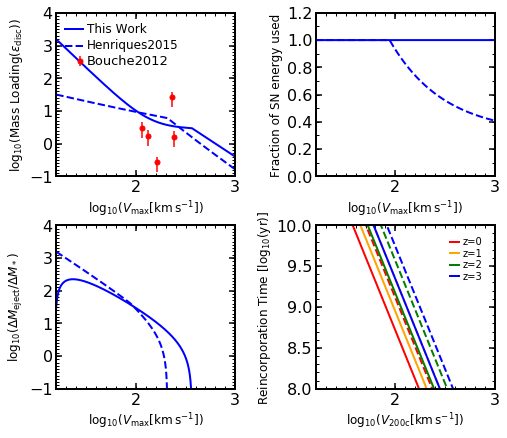

In [54]:
plt.rcParams.update({'xtick.direction': 'in', 'ytick.direction': 'in', 
                     'ytick.right': True, 'xtick.top': True})

SN_Par_Pos=[6,7,8,9,10,11,12]


bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72,0.62,100.,0.80,3.0e+10,
                         0.036,2.5,1.3e+04]))
bestfit=pd.Series(array([0.029, 0.17, 0.54, 0.0, 0.0013, 0.077, 1.2e+03, 1.4, 3.6e+02, 1.6, 3.5, 1.5e+02,1, 
                         1.0e+10,0.32, 1.2, 4.3e+03]))
bestfit=pd.Series(Hen19_best_fit)
#bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72, 0.62,1.0,0.80, 3.0e+10,0.036,2.5,1.3e+04]))

#bestfit=np.log10(bestfit)
#print(bestfit.iloc[SN_Par_Pos])


G=4.3*10**(-9) #Mpc Msun^-1 (km/s)^2
H_z=array([100.0, 170.41, 284.11, 425.86]) #km/s/Mpc
Time_h=array([13.812, 5.850, 3.274, 2.142])
Time_h=Time_h*1.e9
V_max=10**np.arange(1.,5.,0.001)
#V_max=10**np.arange(1.,5.,0.1)


V_SN=630.



#Parameters for bestfit
epsilon_bestfit=bestfit.iloc[SN_Par_Pos[0]]
V_disk_bestfit=bestfit.iloc[SN_Par_Pos[1]]
beta_1_bestfit=bestfit.iloc[SN_Par_Pos[2]]
eta_bestfit=bestfit.iloc[SN_Par_Pos[3]]
V_halo_bestfit=bestfit.iloc[SN_Par_Pos[4]]
beta_2_bestfit=bestfit.iloc[SN_Par_Pos[5]]
gamma_bestfit=bestfit.iloc[SN_Par_Pos[6]]

kagn_bestfit=bestfit.iloc[3]
f_bh_bestfit=bestfit.iloc[4]
V_bh_bestfit=bestfit.iloc[5]
#V_bh=10000.
    
epsilon_halo_bestfit=eta_bestfit*(0.5+(V_max/V_halo_bestfit)**(-beta_2_bestfit))
#print(epsilon_halo_bestfit, eta_bestfit,V_halo_bestfit,beta_2_bestfit)
epsilon_halo_bestfit[epsilon_halo_bestfit > 1.0]=1.0

epsilon_disk_bestfit=epsilon_bestfit*(0.5+(V_max/V_disk_bestfit)**(-beta_1_bestfit))
sel=epsilon_disk_bestfit > epsilon_halo_bestfit*(V_SN**2)/(V_max**2)  
epsilon_disk_bestfit[sel]=epsilon_halo_bestfit[sel]*(V_SN**2)/(V_max[sel]**2)

eject_eff_bestfit=(epsilon_halo_bestfit*(V_SN**2))/(V_max**2)-epsilon_disk_bestfit

quasar_bestfit = f_bh_bestfit/(1+(V_bh_bestfit/V_max)**2)  
redshift = np.arange(0.,10,0.1)
AGN_feedback_bestfit=kagn_bestfit*redshift/redshift

    
#Parameters for Hen15    
epsilon_Hen15 = 2.6
V_disk_Hen15  = 480.
beta_1_Hen15  = 0.72
eta_Hen15     = 0.62
V_halo_Hen15  = 100.
beta_2_Hen15  = 0.8
gamma_Hen15   = 3.0*10**10

f_bh_Hen15    = 0.041
V_bh_Hen15    = 750
kagn_Hen15    = 0.0053

epsilon_halo_Hen15=eta_Hen15*(0.5+(V_max/V_halo_Hen15)**(-beta_2_Hen15))
epsilon_halo_Hen15[epsilon_halo_Hen15 > 1.0]=1.0

epsilon_disk_Hen15=epsilon_Hen15*(0.5+(V_max/V_disk_Hen15)**(-beta_1_Hen15))
sel=epsilon_disk_Hen15 > epsilon_halo_Hen15*(V_SN**2)/(V_max**2)  
epsilon_disk_Hen15[sel]=epsilon_halo_Hen15[sel]*(V_SN**2)/(V_max[sel]**2)

eject_eff_Hen15=(epsilon_halo_Hen15*(V_SN**2))/(V_max**2)-epsilon_disk_Hen15

quasar_Hen15 = f_bh_Hen15/(1+(V_bh_Hen15/V_max)**2) 
AGN_feedback_Hen15=kagn_Hen15*redshift/redshift

plot_color = ['red', 'orange', 'green', 'blue']   

with PdfPages('./fig/plots.pdf') as pdf:  

    #SN    
    fig = plt.figure(figsize=(two_two_size_large[0],two_two_size_large[1])) 
    grid = gridspec.GridSpec(2, 2)
    grid.update(wspace=0.45, hspace=0.3)
    subplots_adjust(top = 0.97, bottom = 0.1, right = 0.97, left = 0.1)
   
    
    #mass loading   
    xlim=[1.2,3.0]   
    ylim=[-1.0, 4.0]
    
    subplot=plt.subplot(grid[0])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)        
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    xlab='$\mathrm{log_{10}}(V_{\mathrm{max}}[\mathrm{km\,s^{-1}}])$'       
    ylab='$\log_{10}$(Mass Loading($\epsilon_{\mathrm{disc}}$))' 
    subplot.set_xlabel(xlab, fontsize=12), subplot.set_ylabel(ylab, fontsize=12)  
    
    
    bouche_Vout     = np.array([131., 231., 162., 116., 240.])
    bouche_sfr      = np.array([1.27, 0.26, 3.75, 1.96, 1.36])
    bouche_Mout     = np.array([2.20, 6.80, 1.00, 6.00, 2.20])
    bouche_Mout_err = np.array([1.10, 3.40, 0.50, 3.00, 1.10])
   
    bouche_loading = bouche_Mout/bouche_sfr
    bouche_loading_err = bouche_Mout_err/bouche_sfr
    
    err_down = np.log10(bouche_loading/(bouche_loading-bouche_loading_err))
    err_up = np.log10((bouche_loading+bouche_loading_err)/bouche_loading)
    subplot.errorbar(np.log10(bouche_Vout), np.log10(bouche_loading), yerr=[err_down,err_up],
                 fmt='o', markersize=5, ecolor='red', color='red')
      
    
    subplot.plot(np.log10(V_max),np.log10(epsilon_disk_bestfit),color='blue', linestyle='-',linewidth=2)         
    subplot.plot(np.log10(V_max),np.log10(epsilon_disk_Hen15),color='blue', linestyle='--',linewidth=2)         
   
    plot_label (subplot, 'label', xlim, ylim,x_percentage=0.17, y_percentage=0.88, color='black', 
                xlog=0, ylog=0, label='This Work', fontsize=12, fontweight='normal')             
    plot_label (subplot,'line',xlim,ylim,x_percentage=0.05,y_percentage=0.9,
                color='blue',x2_percentage=0.15,xlog=0,ylog=0,linestyle='-',linewidth=2)
    plot_label (subplot, 'label', xlim, ylim,x_percentage=0.17, y_percentage=0.78, color='black', 
                xlog=0, ylog=0, label='Henriques2015', fontsize=12, fontweight='normal')             
    plot_label (subplot,'line',xlim,ylim,x_percentage=0.05,y_percentage=0.8,
                color='blue',x2_percentage=0.15,xlog=0,ylog=0,linestyle='--',linewidth=2)

    plot_label (subplot, 'label', xlim, ylim, x_percentage=0.17, y_percentage=0.68, color='black', 
                xlog=0, ylog=0, label='Bouche2012', fontsize=13, fontweight='normal') 
    plot_label (subplot, 'symbol', xlim, ylim, x_percentage=0.13, y_percentage=0.705, 
                color='red', xlog=0, ylog=0, sym='o', sym_size=5, err_size=0.15) 
        
    #SN energy  
    xlim=[1.2,3.0]   
    ylim=[0.0, 1.2]
    
    subplot=plt.subplot(grid[1])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)        
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    subplot.yaxis.set_major_locator(MultipleLocator(0.2)) 
    
    ylab='Fraction of SN energy used' 
    subplot.set_xlabel(xlab, fontsize=12), subplot.set_ylabel(ylab, fontsize=12)  
    
    subplot.plot(np.log10(V_max),epsilon_halo_bestfit,color='blue', linestyle='-', linewidth=2) 
    subplot.plot(np.log10(V_max),epsilon_halo_Hen15,color='blue', linestyle='--', linewidth=2) 
    
    #Ejection  
    xlim=[1.2,3.0]   
    ylim=[-1.0, 4.]
    
    subplot=plt.subplot(grid[2])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)        
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    ylab='$\mathrm{log_{10}}(\Delta M_{\mathrm{eject}}/ \Delta M_*)$' 
    subplot.set_xlabel(xlab, fontsize=12), subplot.set_ylabel(ylab, fontsize=12)  
    
    subplot.plot(np.log10(V_max),np.log10(eject_eff_bestfit),color='blue', linestyle='-', linewidth=2)   
    subplot.plot(np.log10(V_max),np.log10(eject_eff_Hen15),color='blue',  linestyle='--', linewidth=2)   
    
    
    
    #Reincorporation   
    xlim=[1.2,3.0]     
    ylim=[8.0, 10.]
    #xlim=[10.0,13.0]   
    #ylim=[-3, 0.]
    subplot=plt.subplot(grid[3])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim) 
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    xlab='$\mathrm{log_{10}}(V_{\mathrm{200c}}[\mathrm{km\,s^{-1}}])$'            
    ylab='Reincorporation Time [$\log_{10}$(yr)]' 
    subplot.set_xlabel(xlab, fontsize=12), subplot.set_ylabel(ylab, fontsize=12)   
    
    
    for ii in range (0,4): 
        reinc_bestfit=gamma_bestfit*1.e10/(V_max**3/(10.*G*H_z[ii]))      
        subplot.plot(np.log10(V_max),np.log10(reinc_bestfit),color=plot_color[ii], linestyle='-', linewidth=2)
        reinc_Hen15=gamma_Hen15*1.e10/(V_max**3/(10.*G*H_z[ii]))      
        subplot.plot(np.log10(V_max),np.log10(reinc_Hen15),color=plot_color[ii], linestyle='--', linewidth=2)
       
        plot_label (subplot, 'label', xlim, ylim,x_percentage=0.82, y_percentage=0.88-ii*0.07, color='black', 
                xlog=0, ylog=0, label='z='+str(ii), fontsize=10, fontweight='normal')             
        plot_label (subplot,'line',xlim,ylim,x_percentage=0.75,y_percentage=0.9-ii*0.07,
                color=plot_color[ii],x2_percentage=0.8,xlog=0,ylog=0,linestyle='-',linewidth=2)
        
    #print(M_eject/reinc_bestfit)
    yy=np.arange(ylim[0],ylim[1],0.01)
    xx=yy*0.+12.0     
    subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)  
        
    xx=np.arange(xlim[0],xlim[1],0.1)
    yy=xx*0.+0.1   
    subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)      
    
    plt.savefig('./fig/parameter_scalings_sn.pdf')
    plt.tight_layout()    
    pdf.savefig()
    
    
    
    
    
    #BLACK HOLES    
    fig = plt.figure(figsize=(one_two_size_large[0],one_two_size_large[1])) 
    grid = gridspec.GridSpec(1, 2)
    grid.update(wspace=0.45)
    subplots_adjust(top = 0.95, bottom = 0.2, right = 0.95, left = 0.1)
   
    
    #QUASAR   
    xlim=[1.2,3.0]   
    ylim=[-5.5, -0.5]
    
    subplot=plt.subplot(grid[0])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)        
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    xlab='$\mathrm{log_{10}}(V_{\mathrm{200c}}[\mathrm{km\,s^{-1}}])$'       
    ylab='$\log_{10}(\Delta M_{\mathrm{BH,Q}}/M_{\mathrm{cold}})$' 
    subplot.set_xlabel(xlab, fontsize=12), subplot.set_ylabel(ylab, fontsize=12)  
        
    subplot.plot(np.log10(V_max),np.log10(quasar_bestfit),color='blue', linestyle='-',linewidth=2)   
    subplot.plot(np.log10(V_max),np.log10(quasar_Hen15),color='blue', linestyle='--',linewidth=2) 
   
    plot_label (subplot, 'label', xlim, ylim,x_percentage=0.17, y_percentage=0.88, color='black', 
                xlog=0, ylog=0, label='This Work', fontsize=12, fontweight='normal')             
    plot_label (subplot,'line',xlim,ylim,x_percentage=0.05,y_percentage=0.9,
                color='blue',x2_percentage=0.15,xlog=0,ylog=0,linestyle='-',linewidth=2)
    plot_label (subplot, 'label', xlim, ylim,x_percentage=0.17, y_percentage=0.78, color='black', 
                xlog=0, ylog=0, label='Henriques2015', fontsize=12, fontweight='normal')             
    plot_label (subplot,'line',xlim,ylim,x_percentage=0.05,y_percentage=0.8,
                color='blue',x2_percentage=0.15,xlog=0,ylog=0,linestyle='--',linewidth=2)

    #RADIO  
    xlim=[1.2,3.0]   
    ylim=[-4.0, -1.0]
    
    subplot=plt.subplot(grid[1])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)        
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    subplot.yaxis.set_major_locator(MultipleLocator(0.5)) 
    
    xlab='redshift'       
    ylab='$\log_{10}(k_{\mathrm{AGN}}[M_{\odot}\, \mathrm{yr}^{-1}])$' 
    subplot.set_xlabel(xlab, fontsize=12), subplot.set_ylabel(ylab, fontsize=12)  
    
    subplot.plot(redshift,np.log10(AGN_feedback_bestfit),color='blue', linestyle='-', linewidth=2) 
    subplot.plot(redshift,np.log10(AGN_feedback_Hen15),color='blue', linestyle='--', linewidth=2) 
   
  
    
    plt.savefig('./fig/parameter_scalings_agn.pdf')
    
    
    
    plt.tight_layout()    
    pdf.savefig()
    plt.close()    
        
print("scalings done")

# Parameter scalings - Mvir

In [33]:
plt.rcParams.update({'xtick.direction': 'in', 'ytick.direction': 'in'})

SN_Par_Pos=[7,8,9,10,11,12,13]


bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72,0.62,100.,0.80,3.0e+10,0.036,2.5,1.3e+04]))


#bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72, 0.62,1.0,0.80, 3.0e+10,0.036,2.5,1.3e+04]))

#bestfit=np.log10(bestfit)
print(bestfit.iloc[SN_Par_Pos])


G=4.3*10**(-9) #Mpc Msun^-1 (km/s)^2
H_z=array([100.0, 170.41, 284.11, 425.86]) #km/s/Mpc
Time_h=array([13.812, 5.850, 3.274, 2.142])
Time_h=Time_h*1.e9
V_max=10**np.arange(1.,5.,0.001)
#V_max=10**np.arange(1.,5.,0.1)


V_SN=630.

epsilon_bestfit=bestfit.iloc[SN_Par_Pos[0]]
V_disk_bestfit=bestfit.iloc[SN_Par_Pos[1]]
beta_1_bestfit=bestfit.iloc[SN_Par_Pos[2]]
eta_bestfit=bestfit.iloc[SN_Par_Pos[3]]
V_halo_bestfit=bestfit.iloc[SN_Par_Pos[4]]
beta_2_bestfit=bestfit.iloc[SN_Par_Pos[5]]
gamma_bestfit=bestfit.iloc[SN_Par_Pos[6]]

f_bh=bestfit.iloc[5]
V_bh=bestfit.iloc[6]
#V_bh=10000.
    
epsilon_halo_bestfit=eta_bestfit*(0.5+(V_max/V_halo_bestfit)**(-beta_2_bestfit))

epsilon_disk_bestfit=epsilon_bestfit*(0.5+(V_max/V_disk_bestfit)**(-beta_1_bestfit))
sel=epsilon_disk_bestfit > epsilon_halo_bestfit*(V_SN**2)/(V_max**2)  
epsilon_disk_bestfit[sel]=epsilon_halo_bestfit[sel]*(V_SN**2)/(V_max[sel]**2)

eject_eff_bestfit=(epsilon_halo_bestfit*(V_SN**2))/(V_max**2)-epsilon_disk_bestfit

quasar_bestfit = f_bh/(1+(V_bh/V_max)**2) 
quasar_bestfit = f_bh/(1+(V_bh/V_max*V_max/200)**2)    
    
plot_color = ['red', 'orange', 'green', 'blue']   

with PdfPages('./fig/plots.pdf') as pdf:  

     
    fig = plt.figure(figsize=(one_three_size_large[0],one_three_size_large[1])) 
    grid = gridspec.GridSpec(1, 3)
   
    plt.tick_params(axis='x', which='both', direction='in') 
    plt.tick_params(axis='y', which='both', direction='in') 
       
    #ejection    
    xlim=[10.0,13.0]   
    ylim=[-1.0, 3.]
    #xlim=[11.0,15.0] 
    
    xlim=[10.0,12.0]   
    ylim=[-4, 0.]
    ylim=[-1, 3.]
    subplot=plt.subplot(grid[0])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)        
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    xlab='$\mathrm{log_{10}}(M_{\mathrm{vir}}[M_{\odot}])$'      
    ylab='$\mathrm{log_{10}}(\Delta M_{\mathrm{eject}}/ \Delta M_*)$' 
    ylab='$\mathrm{log_{10}}(\Delta M_{\mathrm{eject}}/ \Delta M_{\mathrm{reinc}})$' 
    subplot.set_xlabel(xlab, fontsize=14), subplot.set_ylabel(ylab, fontsize=14)   
   
 
    for ii in range (0,4):    
        M_vir=V_max**3/(10.*H_z[ii]*G)
        MM=200**3/(10.*H_z[ii]*G)
        print(np.log10(MM))
        t_reinc = gamma_bestfit*1e10/(M_vir)
        M_eject = 0.155*M_vir
        #print(eject_eff_bestfit)      
        #print(Time_h[ii])
        #reinc_eff_bestfit=eject_eff_bestfit/t_reinc*Time_h[ii]*0.1
        #print(np.log10(eject_eff_bestfit-reinc_eff_bestfit))      
        #subplot.plot(np.log10(M_vir),np.log10(eject_eff_bestfit-reinc_eff_bestfit),color=plot_color[ii], linestyle='-', linewidth=2)      
        #subplot.plot(np.log10(M_vir),np.log10(eject_eff_bestfit),color=plot_color[ii], linestyle='--', linewidth=2)   
        dt = Time_h[ii]
        dt = 2e7
        M_out = eject_eff_bestfit*dt
        sel = M_out>M_vir*0.155
        M_out[sel] = M_vir[sel]*0.155
                
        M_in = M_vir*0.155/t_reinc*dt      
        sel = M_in>M_vir*0.155
        M_in[sel] = M_vir[sel]*0.155
        
        #subplot.plot(np.log10(M_vir/0.673),np.log10((M_out-M_in)/M_vir),color=plot_color[ii], linestyle='--', linewidth=2)         
        subplot.plot(np.log10(M_vir),np.log10((M_out/M_in)),color=plot_color[ii], linestyle='--', linewidth=2)         
    
    #print(M_vir)
    #print(M_out)
    #print(M_out/M_in)
    
    #yy=np.arange(ylim[0],ylim[1],0.1)
    #xx=yy*0.+12.    
    #subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)  
    
    
    xx=np.arange(xlim[0]-1.,xlim[1]+1.,0.01)
    yy=xx*0.   
    subplot.plot(xx,yy,color='black', linestyle=':', linewidth=3)  
    
    #Reincorporation   
    xlim=[10.0,13.0]     
    ylim=[0.01, 1.]
    #xlim=[10.0,13.0]   
    #ylim=[-3, 0.]
    subplot=plt.subplot(grid[1])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim) 
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    xlab='$\mathrm{log_{10}}(M_{\mathrm{vir}}[M_{\odot}])$'       
    ylab='$t_{\mathrm{reinc}}/t_{H}$' 
    subplot.set_xlabel(xlab, fontsize=14), subplot.set_ylabel(ylab, fontsize=14)   
        
    for ii in range (0,4):            
        M_vir=10**np.arange(10.,15.,0.001)
        reinc_bestfit=gamma_bestfit*1.e10/M_vir/Time_h[ii]
        #t_dyn = R_vir/V_vir = H(z)
        #km/s/Mpc to yr
        t_dyn = 1/(H_z[ii] / (3.086*10**(19))*3.154*10**7)    
        reinc_bestfit=gamma_bestfit*1.e10/M_vir/t_dyn
        #subplot.plot(np.log10(M_vir),np.log10(reinc_bestfit),color='blue', linestyle='-', linewidth=2) 
        subplot.plot(np.log10(M_vir),reinc_bestfit,color=plot_color[ii], linestyle='-', linewidth=2) 
        
        #dt = 1e7
        #M_eject = M_vir*0.155
        #reinc_bestfit=(gamma_bestfit*1e10/M_vir)
        #reinc_bestfit=gamma_bestfit*1.e10/M_vir
        #subplot.plot(np.log10(M_vir),np.log10(reinc_bestfit),color='blue', linestyle='-', linewidth=2) 
        
        #M_reinc = M_eject/reinc_bestfit*Time_h[ii]*0.1
        #sel = M_reinc>M_vir*0.155
        #M_reinc[sel] = M_vir[sel]*0.155
        #subplot.plot(np.log10(M_vir),np.log10(M_reinc/M_vir),color=plot_color[ii], linestyle='-', linewidth=2) 
        
    #print(M_eject/reinc_bestfit)
    yy=np.arange(ylim[0],ylim[1],0.01)
    xx=yy*0.+12.0     
    subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)  
        
    xx=np.arange(xlim[0],xlim[1],0.1)
    yy=xx*0.+0.1   
    subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)      
    
    
    #quasar mode
    xlim=[10.,15.]   
    ylim=[-5., -1.]
   
    subplot=plt.subplot(grid[2])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim) 
    subplot.xaxis.set_minor_locator(MultipleLocator(0.1))    
    subplot.yaxis.set_minor_locator(MultipleLocator(0.1)) 
    
    xlab='$\log_{10}(M_{\mathrm{vir}}[M_{\odot}])$'       
    ylab='$\log_{10}(\Delta M_{\mathrm{BH,Q}}/M_{\mathrm{cold}})$' 
    subplot.set_xlabel(xlab, fontsize=14), subplot.set_ylabel(ylab, fontsize=14)   
     
    M_vir=10**np.arange(xlim[0],xlim[1],0.001)
    
    for ii in range (0,4):
        M_vir=V_max**3/(10.*H_z[ii]*G)
        subplot.plot(np.log10(M_vir),np.log10(quasar_bestfit),color=plot_color[ii], linestyle='-', linewidth=2) 
    
    yy=np.arange(ylim[0],ylim[1],0.01)
    xx=yy*0.+12.0     
    subplot.plot(xx,yy,color='black', linestyle='--', linewidth=3)  
    
    plt.tight_layout() 
    grid.update(wspace=0.4, hspace=0.0)
    pdf.savefig()
    plt.close()    
        
print("scalings done")

7     2.600000e+00
8     4.800000e+02
9     7.200000e-01
10    6.200000e-01
11    1.000000e+02
12    8.000000e-01
13    3.000000e+10
dtype: float64
12.269621531412357
12.038126454964127
11.816135011281862
11.64035468165346


/usr/lib/python3/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log10


scalings done


# Parameter Scalings for Cold Gas Mass

In [28]:
SN_Par_Pos=[7,8,9,10,11,12,13]
AGN_Par_Pos=[4,5,6]

bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72,0.62,100.,0.80,3.0e+10,0.036,2.5,1.3e+04]))


#bestfit=pd.Series(array([0.025,0.24,0.60,1.9,0.0053,0.041,750,2.6,480.,0.72, 0.62,1.0,0.80, 3.0e+10,0.036,2.5,1.3e+04]))

#bestfit=np.log10(bestfit)
print(bestfit.iloc[SN_Par_Pos])



redshift=array([0.0,1.0,2.0,3.0])
zplus1 = 1 + redshift
Hubble = 0.673*3.2407789e-18  * 3.08568e+24 / 100000.
Omega_M=0.315
Omega_Lambda=0.685 
H_z=Hubble * sqrt(Omega_M*zplus1*zplus1*zplus1+(1-Omega_M-Omega_Lambda)*zplus1*zplus1+Omega_Lambda)

G=4.3*10**(-9) #Mpc Msun^-1 (km/s)^2
#H_z=array([100.0, 170.41, 284.11, 425.86]) #km/s/Mpc
Time_h=array([13.812, 5.850, 3.274, 2.142])
Time_h=Time_h*1.e9
V_max=10**np.arange(1.,4.,0.0001)
#V_max=10**np.arange(1.0,3.5,0.1)
V_SN=630.

epsilon_bestfit=bestfit.iloc[SN_Par_Pos[0]]
V_disk_bestfit=bestfit.iloc[SN_Par_Pos[1]]
beta_1_bestfit=bestfit.iloc[SN_Par_Pos[2]]
eta_bestfit=bestfit.iloc[SN_Par_Pos[3]]
V_halo_bestfit=bestfit.iloc[SN_Par_Pos[4]]
beta_2_bestfit=bestfit.iloc[SN_Par_Pos[5]]
gamma_bestfit=bestfit.iloc[SN_Par_Pos[6]]
k_AGN_bestfit=bestfit.iloc[AGN_Par_Pos[0]]
    
epsilon_halo_bestfit=eta_bestfit*(0.5+(V_max/V_halo_bestfit)**(-beta_2_bestfit))

epsilon_disk_bestfit=epsilon_bestfit*(0.5+(V_max/V_disk_bestfit)**(-beta_1_bestfit))
sel=epsilon_disk_bestfit > epsilon_halo_bestfit*(V_SN**2)/(V_max**2)  
epsilon_disk_bestfit[sel]=epsilon_halo_bestfit[sel]*(V_SN**2)/(V_max[sel]**2)

eject_eff_bestfit=(epsilon_halo_bestfit*(V_SN**2))/(V_max**2)-epsilon_disk_bestfit
    
   

with PdfPages('./fig/plots.pdf') as pdf:  

   
     
    fig = plt.figure(figsize=(one_one_size_small[0],one_one_size_small[1])) 
    #grid = gridspec.GridSpec(1, 2)
    
       
      
    #format axis
    #majorFormatter = FormatStrFormatter('%d')
    #subplot.xaxis.set_major_locator(MultipleLocator(1))    
    #subplot.xaxis.set_minor_locator(MultipleLocator(0.5)) 

    #ejection    
    xlim=[11.0,14.5]   
    ylim=[-4.0, 0.0]
    subplot=plt.subplot()
    subplot.set_ylim(ylim), subplot.set_xlim(xlim) 
    
    xlab='$\mathrm{log_{10}}(M_{\mathrm{vir}}[M_{\odot}])$'      
    ylab='$\mathrm{log_{10}}(\Delta M_{\mathrm{cold}}/ \Delta M_{\mathrm{vir}})$' 
    subplot.set_xlabel(xlab, fontsize=14), subplot.set_ylabel(ylab, fontsize=14)   
        
    #for ii in range (0,4):    
    #    M_vir=V_max**3/(10.*H_z[ii]*G)
    #    subplot.plot(np.log10(M_vir),np.log10(eject_eff_bestfit),color='blue', linestyle='-', linewidth=2)         
     
    M_vir=V_max**3/(10.*H_z[0]*G)
    fb=0.155
    M_bar=fb*M_vir    
    subplot.plot(np.log10(M_vir),np.log10(M_bar/M_vir),color='black', linestyle='--', linewidth=2)
    print("Mvir")
    print(M_vir)
    
    reinc_bestfit=gamma_bestfit*1.e10/M_vir
    #km/s/Mpc
    #t_dyn=0.1/H_z[0]    
    #yr    
    km_in_Mpc=3.09*1e19
    sec_in_years=3.154*1e7
    t_dyn=0.1/(H_z[0]/(km_in_Mpc/(sec_in_years)))
    dt=13.7*1e9
    dt=t_dyn
    
    #SFR=10**(2.2*np.log10(M_vir)-25.6)
    #SFR=10**(1.0*np.log10(M_vir)-12.)
    SFR=10**(1.17*np.log10(M_vir)-14.)
    #SFR=10**(1.33*np.log10(M_vir)-16.)    
    #SFR=10**(1.67*np.log10(M_vir)-19.5)
       
    eta=0.1
    c_light=3e5 #km/s    
       
    
    '''#M_vir_set=1e11
    #alpha=fb*M_vir_set*(t_dyn+dt)/(M_vir_set**0.76*dt*dt)
    M_vir_set=10**14.5
    M_star_over_Mvir=0.018  
    M_hot_over_Mvir=fb
    alpha=M_star_over_Mvir*(t_dyn+dt)*t_dyn/(M_hot_over_Mvir**(3./2.)*dt*dt)*M_vir_set**(0.43)
    #alpha=M_star_over_Mvir*(t_dyn+dt)*t_dyn/(M_hot_over_Mvir**(3./2.)*dt*dt)*M_vir_set**(0.5)
       
    M_reheat=epsilon_disk_bestfit*SFR*dt
    M_eject=eject_eff_bestfit*SFR*dt
      
    sel=M_eject>fb*M_vir
    M_eject[sel]=fb*M_vir[sel]
    M_reinc=(M_eject/reinc_bestfit)*dt
    sel=M_reinc>M_eject
    M_reinc[sel]=M_eject[sel]
    
    M_hot=fb*M_vir-M_eject+M_reinc#+M_reheat #+M_reheat-M_eject+M_reinc     
    M_cooling=alpha*M_hot**(3./2.)*M_vir**(-0.93)/t_dyn*dt
    #M_cooling=alpha*M_hot**(3./2.)*M_vir**(-1.0)/t_dyn*dt
    M_cooling[M_cooling>fb*M_vir]=fb*M_vir[M_cooling>fb*M_vir]
   
    M_hot=M_hot-M_cooling-M_eject+M_reinc#+M_reheat #+M_reinc#+M_reheat  
    M_cold=M_cooling/((t_dyn+dt)/t_dyn)#-M_reheat
    #M_cold=alpha*M_hot**(3./2.)*M_vir**(-1.07)*dt/(t_dyn+dt)
    M_star=M_cold/t_dyn*dt'''
    
    
    
    
    
    
    
    M_star=np.zeros(len(M_vir))
    M_cold=np.zeros(len(M_vir))
    M_eject=np.zeros(len(M_vir))
    M_reinc=np.zeros(len(M_vir))
    M_hot=np.zeros(len(M_vir))
    
    #sel=M_vir<10**11.94  
    sel=M_vir<10**11.75 
    M_star[sel]=fb*M_vir[sel]/(t_dyn+eject_eff_bestfit[sel]*dt)*dt 
    #M_cold[sel]=M_star[sel]*t_dyn/dt    
    #M_eject[sel]=eject_eff_bestfit[sel]*M_star[sel]/t_dyn*dt
    #M_reinc[sel]=0.
        
    #Mvir=1.16e+12 Mcooling=2.28e+01
    #Mvir=1.12e+13 Mcooling=6.58e+01
    #Mvir=1.03e+14 Mcooling=1.34e+02
    #print((0.1*1.e12**(1.5-0.93)*(t_dyn**0.5))/t_dyn)
    #print((0.1*1.e13**(1.5-0.93)*(t_dyn**0.5))/t_dyn)
    #print((0.1*1.e14**(1.5-0.93)*(t_dyn**0.5))/t_dyn)
    #print(22.8,65.8,134)
    alpha=0.1
    cooling_alpha=0.93
    
    #sel=(M_vir>10**11.75) & (M_vir<10**11.94)    
    #M_star[sel]=(alpha*M_vir[sel]**(1.5-cooling_alpha)*(t_dyn**0.5))/t_dyn*dt/(1.+eject_eff_bestfit[sel])    
    #M_cold[sel]=M_star[sel]*t_dyn/dt    
    #M_eject[sel]=eject_eff_bestfit[sel]*M_star[sel]/t_dyn*dt
    #M_reinc[sel]=0.
        
    M_BH=10**(1.15*np.log10(M_vir)-7.15)
    M_hot=fb*M_vir  
    M_AGN=(k_AGN_bestfit/1e19)*M_hot*M_BH*2*eta*(c_light**2/V_max**2)*(1e10/9.780285e+11)*dt
    M_AGN[M_AGN<0.]=0.    
    sel=M_AGN>(alpha*(t_dyn**0.5)*M_vir**(1.5-cooling_alpha))/t_dyn*dt
    M_AGN[sel]=(alpha*(t_dyn**0.5)*M_vir[sel]**(1.5-cooling_alpha))/t_dyn*dt
    
    #sel=(M_vir>10**11.94)  
    sel=(M_vir>10**11.75)  
    M_star[sel]=((alpha*(t_dyn**0.5)*M_vir[sel]**(1.5-cooling_alpha))/t_dyn*dt-M_AGN[sel])/t_dyn*dt 
    M_cold[sel]=M_star[sel]*t_dyn/dt    
    M_eject[sel]=0.
    M_reinc[sel]=0.
  
    

    subplot.plot(np.log10(M_vir),np.log10((M_star)/M_vir),color='blue', linestyle='-', linewidth=2)
    #subplot.plot(np.log10(M_vir),np.log10((M_AGN)/M_vir),color='brown', linestyle='-', linewidth=2)
  
    plt.tight_layout() 
    grid.update(wspace=0.4, hspace=0.0)
    pdf.savefig()
    plt.close()    
        
print("scalings done")

7     2.600000e+00
8     4.800000e+02
9     7.200000e-01
10    6.200000e-01
11    1.000000e+02
12    8.000000e-01
13    3.000000e+10
dtype: float64
Mvir
[3.45554213e+08 3.45792996e+08 3.46031944e+08 ... 3.44838853e+17
 3.45077142e+17 3.45315595e+17]
scalings done


/usr/lib/python3/dist-packages/ipykernel_launcher.py:181: RuntimeWarning: divide by zero encountered in log10


# Chain Walks

In [193]:
plt.rcParams.update({'font.size': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 1.5, 
                     'ytick.major.size': 6, 'ytick.major.width': 1.5, 
                     'xtick.minor.size': 3, 'xtick.minor.width': 1.,                   
                     'ytick.minor.size': 3, 'ytick.minor.width': 1.})  


with PdfPages('./fig/plots.pdf') as pdf:  
        
    for ii in range (0, N_par): 
       
        if((ii==0) | (ii==7) | (ii==14)):
            fig = plt.figure(figsize=(25,4))
            grid = gridspec.GridSpec(1, 7)            
            i_grid=0
              
        subplot=plt.subplot(grid[i_grid])
        i_grid+=1
      
        ylim=[10**min(df.iloc[:,ii+2]),10**max(df.iloc[:,ii+2])]
        ylim=[max(ylim[0]-(ylim[1]-ylim[0])/2.,ylim[0]/2.),ylim[1]+(ylim[1]-ylim[0])/2.]      
        Max_Nsteps=200
        xlim=[0, Max_Nsteps]         
        subplot.set_ylim(ylim), subplot.set_xlim(xlim)
           
        
        #format axis
        majorFormatter = FormatStrFormatter('%d')
        #subplot.xaxis.set_major_locator(MultipleLocator(1))    
        #subplot.xaxis.set_minor_locator(MultipleLocator(0.25)) 
                          
        subplot.set_xlabel('step', fontsize=14) 
        subplot.set_ylabel(Par_Names[ii], fontsize=14)    
        #plt.tick_params(axis='y', which='both', left='on', labelleft='off')
               
        x_axis=np.arange(0,Max_Nsteps,1.0)   
        
        for jj in range(0,N_chains):
            char_jj="%d" % jj  
            aux_df=pd.read_csv(chains_dir+chains_file+'_'+char_jj+'.txt',sep=' ',header=None)        
            subplot.plot(x_axis[0:len(aux_df.iloc[:,ii+2])],10**aux_df.iloc[:,ii+2], 
                         color='blue', linewidth=2, linestyle='-') 
         
         
        #plot 2-sigma regions         
        subplot.fill_between(x_axis,np.zeros(len(x_axis))+10**lower[ii],
                             np.zeros(len(x_axis))+10**upper[ii],
                             facecolor='skyblue', interpolate=True, alpha=0.4, edgecolor='skyblue')  
         
     

        if((ii==6) | (ii==13) | (ii==N_par-1)):    
            plt.tight_layout() 
            grid.update(wspace=0.2, hspace=0.0)
            pdf.savefig()
            plt.close()

print("plots done")

plots done


# 2D plots

In [10]:
from scipy.interpolate import griddata

plt.rcParams.update({'font.size': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 1.5, 
                     'ytick.major.size': 6, 'ytick.major.width': 1.5, 
                     'xtick.minor.size': 3, 'xtick.minor.width': 1.,                   
                     'ytick.minor.size': 3, 'ytick.minor.width': 1.})  


with PdfPages('./fig/plots.pdf') as pdf:  
    
    for ii in range (0, N_par-13): 
        print(ii)
        fig = plt.figure(figsize=(35,4))
        grid = gridspec.GridSpec(1, N_par-1)
        #grid.update(wspace=0.0, hspace=0.0)
        i_grid=0
        
        loop_count=0       
        for jj in range (0, N_par):
            
            
            if(jj==ii):
                continue
          
            subplot=plt.subplot(grid[i_grid])
            i_grid+=1
      
            plot_range=0.6
            median=(min(df.iloc[:,jj+2])+max(df.iloc[:,jj+2]))/2.
            xlim=[median-plot_range/2.,median+plot_range/2.]             
            median=(min(df.iloc[:,ii+2])+max(df.iloc[:,ii+2]))/2.
            ylim=[median-plot_range/2.,median+plot_range/2.]
            subplot.set_ylim(ylim), subplot.set_xlim(xlim)
           
       
            subplot.set_xlabel(Par_Names[jj], fontsize=14)
            if(loop_count==0):
                subplot.set_ylabel(Par_Names[ii], fontsize=14)    
            if(loop_count>0):                 
                plt.tick_params(axis='y', which='both', left='on', labelleft='off')
                
            subplot.xaxis.set_major_locator(MultipleLocator(0.25))    
            subplot.xaxis.set_minor_locator(MultipleLocator(0.1))     
            
            x_axis=df.iloc[:,jj+2]
            y_axis=df.iloc[:,ii+2]
            z_axis=df.iloc[:,1]
                
         
            xi,yi = np.mgrid[xlim[0]:xlim[1]:10j, ylim[0]:ylim[1]:10j]          
            zi = griddata((x_axis, y_axis), z_axis, (xi, yi), method='cubic', fill_value=300.)
            #contour the gridded data, plotting dots at the nonuniform data points.
            #nearest linear cubic
         
            zi=np.log10(zi/np.amax(zi))  
           
            zi = zoom(zi, 1)  
            #print(zi)
                
            mylevels = np.log10(np.logspace(-1.0, -0.0001, num=20))        
            cont=plt.contourf(zi, origin='lower', cmap='Greys', 
                              levels=mylevels, extent=[xlim[0],xlim[1],ylim[0], ylim[1]])  
            #cont=plt.contourf(zi, origin='lower', cmap='Greys', extent=[xlim[0],xlim[1],ylim[0], ylim[1]])  
            
            
            Nbins=20
            Hist, xedges, yedges = np.histogram2d(x_axis, y_axis, bins=Nbins,
                                               range=[[xlim[0]-0.5, xlim[1]+0.5], [ylim[0]-0.5, ylim[1]+0.5]])            
            extent = [xedges[0], xedges[-1],yedges[0], yedges[-1]]       
            plt.subplots_adjust(bottom=0.15, left=0.15)     
            mylevels = np.log10(np.logspace(-2.0, 0.0, num=3))  
            mylevels = np.log10([1-0.955,1.-0.683,1])
            Hist = zoom(Hist, 30)        
            Hist=np.log10(Hist/np.amax(Hist))       
            cont=plt.contour(Hist.transpose()[::], origin='lower', colors='black', 
                             levels=mylevels, extent=extent, linestyles='-')  

            loop_count+=1
            
        plt.tight_layout()  
        grid.update(wspace=0.05, hspace=0.0)
        pdf.savefig()
        plt.close()

print("plots done")

0


/usr/lib/python3/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log10
/home/brunohe/.local/lib/python3.6/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/brunohe/.local/lib/python3.6/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/usr/lib/python3/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in log10
/home/brunohe/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


1
plots done
